### CONFIG:

In [1]:
UPDATE_SCORES = False
TRAK_SAVE_DIR = "TRAK/trak_results_v2"

from utils.config import Project_Config, Model_Config, CIFAR_10_Config

project_config = Project_Config(
    IS_CUDA = True,
    IS_WINDOWS = False,
)

model_config = Model_Config(
    PROJECT_CONFIG=project_config,
    MODEL_DIR="sd1-cifar10-v2",
    NUM_CHECKPOINTS=10,
    ITERATIONS_PER_CHECKPOINT=10000,
)

dataset_config = CIFAR_10_Config(new_image_column_name="image",
                                 new_caption_column_name="label_txt")

/home/joy/miniconda3/envs/SD3HF_Unstable/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/joy/miniconda3/envs/SD3HF_Unstable/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/home/joy/miniconda3/envs/SD3HF_Unstable/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")


### Imports:

In [2]:
import torch
from transformers import CLIPTokenizer, CLIPTextModel
from diffusers import AutoencoderKL, UNet2DConditionModel
from torchvision import transforms
from tqdm import tqdm
from torch.utils.data import DataLoader
from datasets import load_dataset, Dataset

/home/joy/Lboro/CodeServer/git/Data-Attribution-for-Stable-Diffusion/utils/config.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpts = [torch.load(ckpt, map_location

Dataset({
    features: ['image', 'label_txt'],
    num_rows: 50000
})


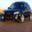

In [3]:
p = model_config.getModelDirectory()
ckpts = model_config.loadCheckpoints(p, CONVERT_SAFETENSORS_TO_CKPT=False)
tokenizer, text_encoder, vae, unet = model_config.loadModelComponents(p)

text_encoder.to("cuda")
vae.to("cuda")
unet.to("cuda")

# Freeze vae and text_encoder
vae.requires_grad_(False)
text_encoder.requires_grad_(False)
#unet.train()


train_dataset = dataset_config.preprocess(tokenizer)
print(train_dataset)

# DataLoaders creation:
train_dataloader = DataLoader(
    train_dataset,
    shuffle=False,
    collate_fn=dataset_config.collate_fn,
    batch_size=1,
)

dataset_config.dataset[6]['image']
train_dataset[6]["image"]

In [4]:
from trak import TRAKer
from TRAK.SD1ModelOutput import SD1ModelOutput

traker = TRAKer(model=unet,
                task=SD1ModelOutput,
                train_set_size=len(train_dataloader.dataset),
                save_dir=TRAK_SAVE_DIR,
                proj_max_batch_size=8, #Default 32, requires an A100 apparently
                proj_dim=1024,
                )

INFO:TRAK:Using ChunkedCudaProjector with2 chunks of sizes[518204160, 341316804].
INFO:STORE:Existing model IDs in /home/joy/Lboro/CodeServer/git/Data-Attribution-for-Stable-Diffusion/TRAK/trak_results_v2: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
INFO:STORE:Model IDs that have been finalized: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
INFO:STORE:Existing TRAK scores:
INFO:STORE:SD1_CIFAR10_v2: /home/joy/Lboro/CodeServer/git/Data-Attribution-for-Stable-Diffusion/TRAK/trak_results_v2/scores/SD1_CIFAR10_v2.mmap


In [5]:
#Scoop whatever VRAM we can because this is going to be a tight fit
import gc
gc.collect()
torch.cuda.empty_cache()

Dataset({
    features: ['image', 'label_txt'],
    num_rows: 10
})
frog


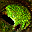

In [6]:
dummy_dataset_path = "./generated_images/1"
seed = 1
generator = torch.Generator(device="cuda").manual_seed(seed)

dummy_dataset = load_dataset('imagefolder', data_dir=dummy_dataset_path, split='train')

#Purely to keep consistent this with the source dataset
if dataset_config.image_column != "image":
    dummy_dataset = dummy_dataset.rename_column("image", dataset_config.image_column)
cl = dummy_dataset.features["label"]

#dummy_dataset = dummy_dataset.map(convertLabel)
dummy_dataset = dummy_dataset.map(lambda x, cIn, cOut: {cOut: cl.int2str(x[cIn])}, 
                                        fn_kwargs={
                                            "cIn": "label", 
                                            "cOut": dataset_config.caption_column
                                            }
                                        )

dummy_dataset = dummy_dataset.remove_columns(column_names=["label"])

print(dummy_dataset)
print(dummy_dataset[6][dataset_config.caption_column])
dummy_dataset[6][dataset_config.image_column]

In [7]:
preprocessed_dummy_dataset = dummy_dataset.with_transform(dataset_config.preprocess_train)

dummy_dataloader = DataLoader(
    preprocessed_dummy_dataset,
    shuffle=False,
    collate_fn=dataset_config.collate_fn,
    batch_size=1,
)

In [8]:
weight_dtype = torch.float32

if UPDATE_SCORES:
    for model_id, ckpt in enumerate(tqdm(ckpts)):
        traker.start_scoring_checkpoint(exp_name='SD1_CIFAR10_v2',

                                            checkpoint=ckpt,

                                            model_id=model_id,

                                            num_targets=len(dummy_dataloader.dataset))

        for batch in tqdm(dummy_dataloader):
                if project_config.IS_CUDA:
                    batch = [x.cuda() for y,x in batch.items()]
                else:
                    batch = [x for y,x in batch.items()]
                image = batch[0]
                tokens = batch[1]
                # Convert images to latent space
                latents = vae.encode(image.to(weight_dtype)).latent_dist.sample()
                latents = latents * vae.config.scaling_factor
                encoder_hidden_states = text_encoder(tokens, return_dict=False)[0]

                batch = [latents, encoder_hidden_states]
                traker.score(batch=batch, num_samples=batch[0].shape[0])

    scores = traker.finalize_scores(exp_name='SD1_CIFAR10_v2')

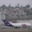

In [9]:
train_dataset[0]["image"]

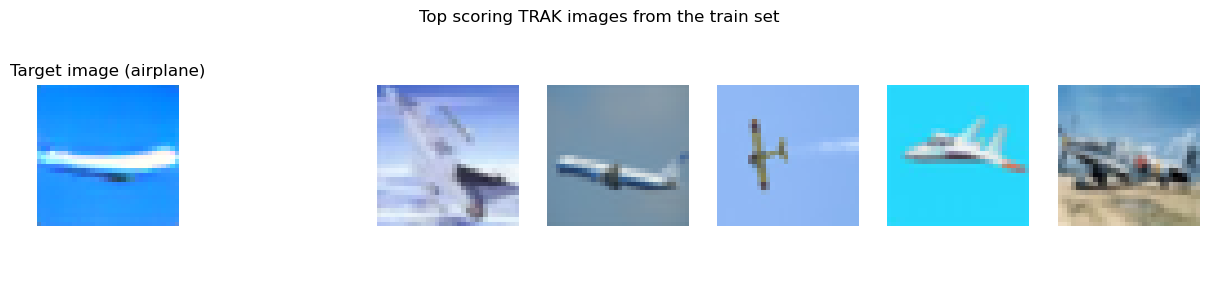

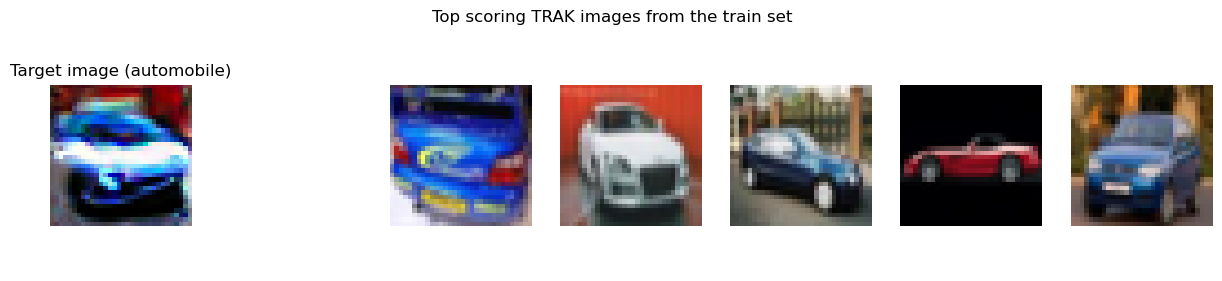

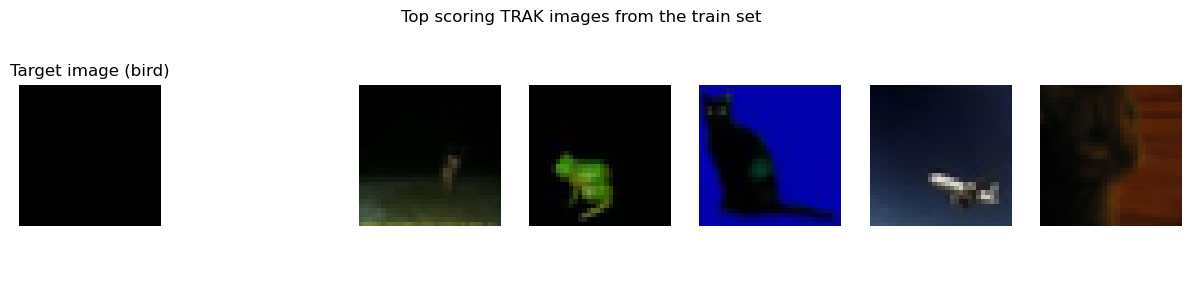

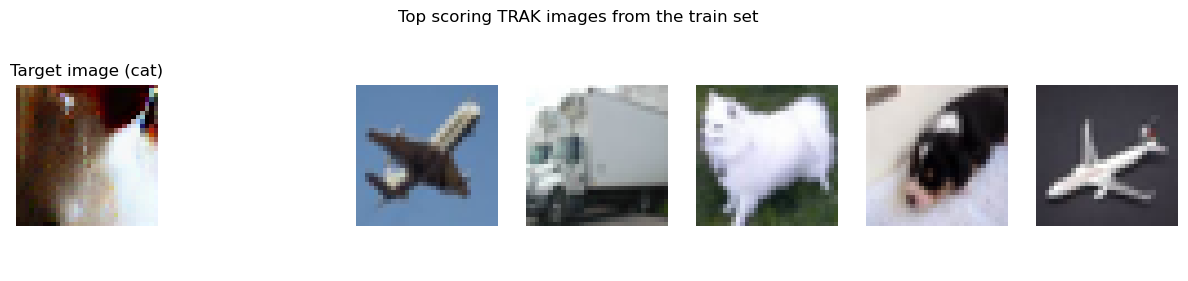

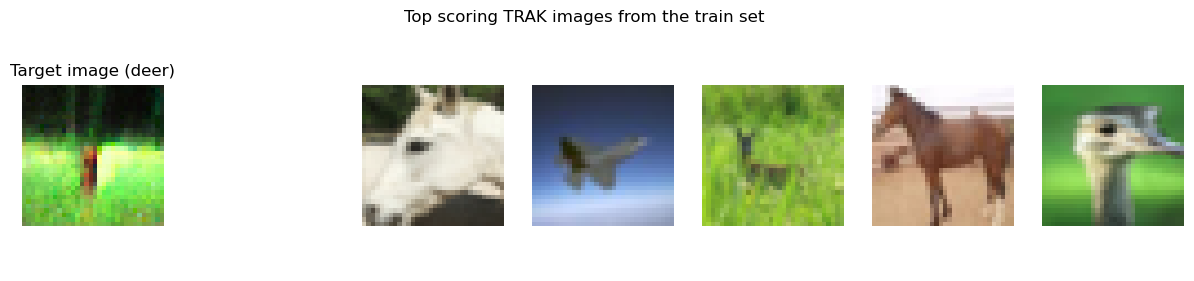

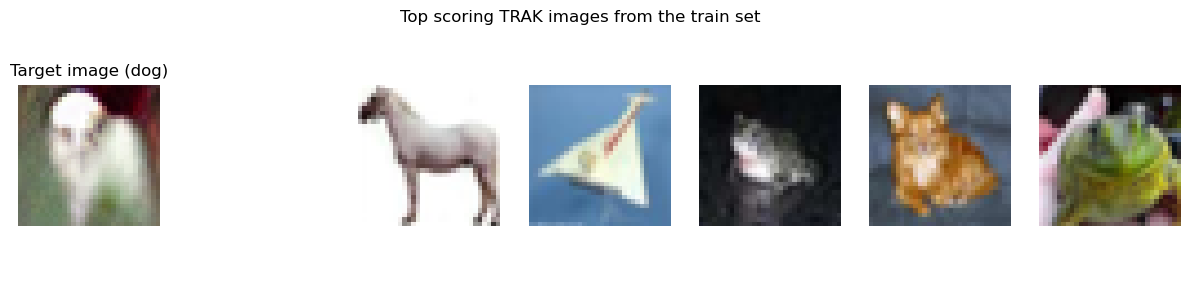

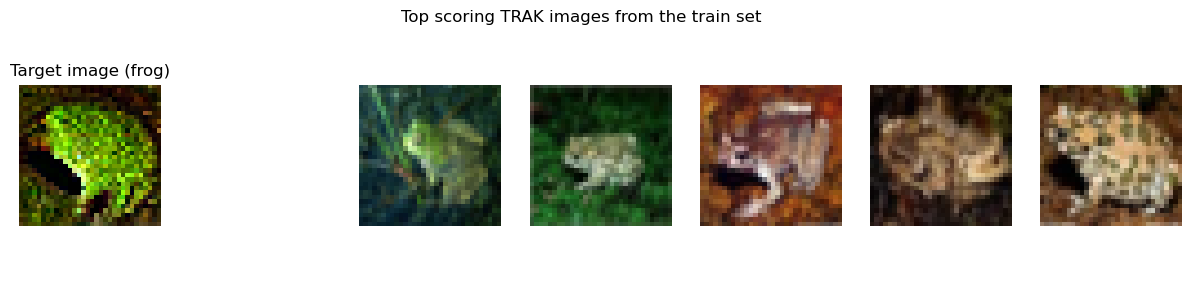

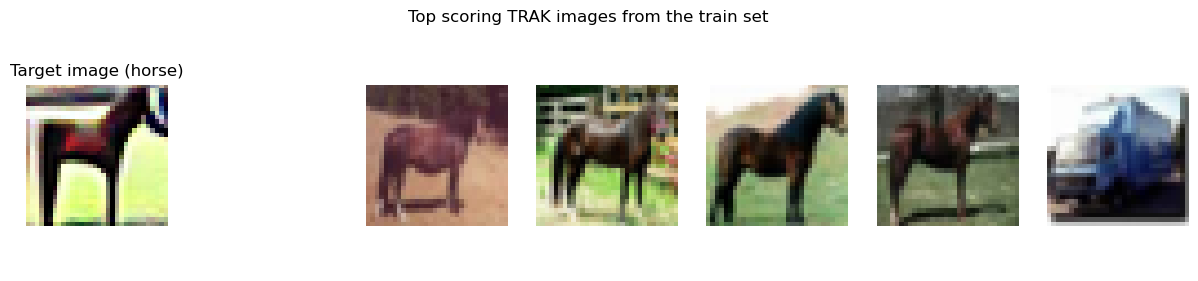

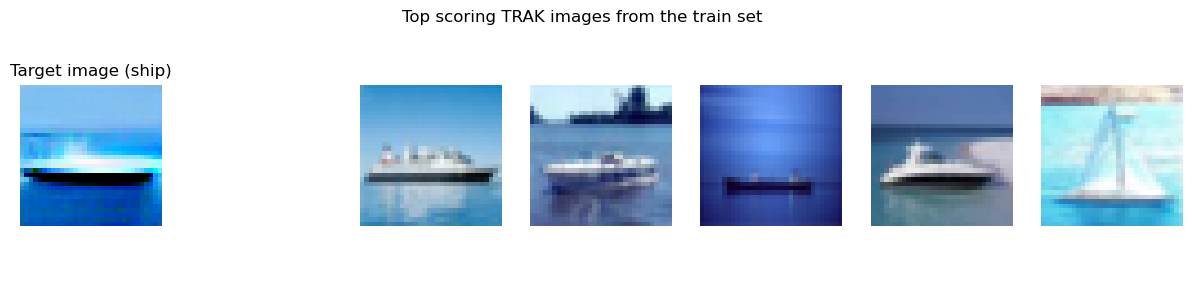

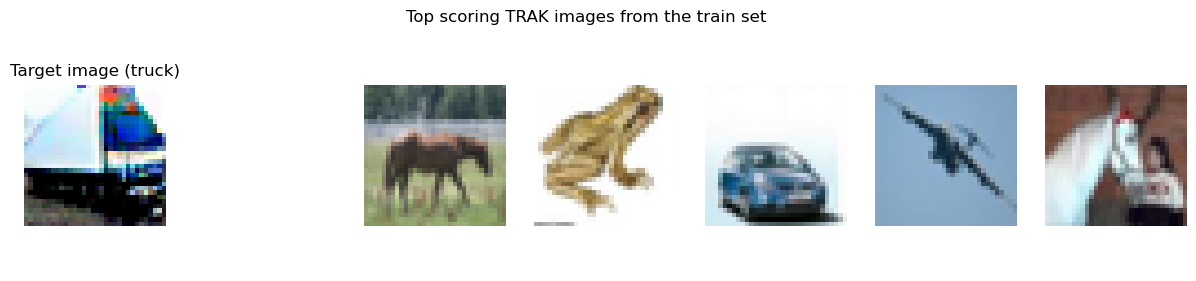

In [10]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

#Adapted from https://github.com/MadryLab/trak/blob/main/examples/cifar_quickstart.ipynb

from numpy.lib.format import open_memmap
scores = open_memmap('./TRAK/trak_results_v2/scores/SD1_CIFAR10_v2.mmap')

for i in range(10): #[6]:

    fig, axs = plt.subplots(ncols=7, figsize=(15, 3))
    fig.suptitle('Top scoring TRAK images from the train set')
    
    axs[0].imshow(dummy_dataset[i][dataset_config.image_column])
    
    axs[0].axis('off'); axs[0].set_title('Target image' + " (" + dummy_dataset[i][dataset_config.caption_column] + ")")
    axs[1].axis('off')
    
    top_trak_scorers = scores[:, i].argsort()[-5:][::-1]
    for ii, train_im_ind in enumerate(top_trak_scorers):
        axs[ii + 2].imshow(train_dataset[int(train_im_ind)][dataset_config.image_column]); axs[ii + 2].axis('off')

    fig.show()